# EDA
Be creative!

In [1]:
import pandas as pd
import sklearn
pd.set_option('display.max_columns', None)
import seaborn as sns
import matplotlib.pyplot as plt

/Users/ivanpua/opt/anaconda3/envs/ml/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
data = pd.read_csv("data.csv")

# Initial Exploration

In [3]:
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
data.info(show_counts = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


Findings:
* CustomerID is the ID column, can be dropped for EDA
* Churn is our label
* Many features have an 'object' datatype, and its absd as it causes headache in plotting graphs on EDA, and consume a lot of compute reosurces
* TotalCharges should be numeric -- suspect there might be a string or NULL values which resulted it to be an object

In [5]:
data.drop("customerID", axis = 1, inplace=True)

# Preprocessing

## Convert Object to Numeric Type

In [6]:
df = data.copy()

In [7]:
# https://stackoverflow.com/questions/15891038/change-column-type-in-pandas

df["TotalCharges"] = pd.to_numeric(df["TotalCharges"],errors='coerce')

## Encoding Categorical Features
We should do this first before doing any EDA. Good software eng practice to convert every string feature to numerical. Easy now because its only 1MB, but imagein 10GB of object type data

In [8]:
def unique_counts(df, columns):
    '''Prints the unique values in a column'''
    
    for col in columns:
        values = sorted(df[col].unique())
        
        if len(values) != 2:
            
            print(f"ALERT: {col} has {len(values)} unique values")
            print(values)
        
        else:
            if values[0] != 'No' and values[0] != 'Yes':
                print(f"ALERT:{col} has 2 unique values which are not 'Yes' or 'No'.")
                print(values) 
            else:
                print(f"{col} has exactly 2 unique values of 'Yes' and 'No'.")
                
    

Some columns are either 'Yes' or 'No', some have additional class called 'No phone/internet service'. To be catious, 'No' and 'no phone/internet service' are different -- consult SME

In [9]:
# Categorical boolean mask
categorical_feature_mask = df.dtypes==object
# filter categorical columns using mask and turn it into a list
categorical_cols = df.columns[categorical_feature_mask].tolist()

In [10]:
unique_counts(df, categorical_cols)

ALERT:gender has 2 unique values which are not 'Yes' or 'No'.
['Female', 'Male']
Partner has exactly 2 unique values of 'Yes' and 'No'.
Dependents has exactly 2 unique values of 'Yes' and 'No'.
PhoneService has exactly 2 unique values of 'Yes' and 'No'.
ALERT: MultipleLines has 3 unique values
['No', 'No phone service', 'Yes']
ALERT: InternetService has 3 unique values
['DSL', 'Fiber optic', 'No']
ALERT: OnlineSecurity has 3 unique values
['No', 'No internet service', 'Yes']
ALERT: OnlineBackup has 3 unique values
['No', 'No internet service', 'Yes']
ALERT: DeviceProtection has 3 unique values
['No', 'No internet service', 'Yes']
ALERT: TechSupport has 3 unique values
['No', 'No internet service', 'Yes']
ALERT: StreamingTV has 3 unique values
['No', 'No internet service', 'Yes']
ALERT: StreamingMovies has 3 unique values
['No', 'No internet service', 'Yes']
ALERT: Contract has 3 unique values
['Month-to-month', 'One year', 'Two year']
PaperlessBilling has exactly 2 unique values of 'Ye

None of the features have ordinality (e.g. a natural order like cold, warm, hot). We can still use OrdinalEncoder() with arbritary numbers

In [11]:
from sklearn.preprocessing import OrdinalEncoder
encoder = OrdinalEncoder(dtype = 'int64')

# apply Ordinal Encoder on categorical feature columns
df[categorical_cols] = encoder.fit_transform(df[categorical_cols])

In [12]:
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0,0,1,0,1,0,1,0,0,2,0,0,0,0,0,1,2,29.85,29.85,0
1,1,0,0,0,34,1,0,0,2,0,2,0,0,0,1,0,3,56.95,1889.50,0
2,1,0,0,0,2,1,0,0,2,2,0,0,0,0,0,1,3,53.85,108.15,1
3,1,0,0,0,45,0,1,0,2,0,2,2,0,0,1,0,0,42.30,1840.75,0
4,0,0,0,0,2,1,0,1,0,0,0,0,0,0,0,1,2,70.70,151.65,1


In [13]:
df.info(show_counts = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   int64  
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   int64  
 3   Dependents        7043 non-null   int64  
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   int64  
 6   MultipleLines     7043 non-null   int64  
 7   InternetService   7043 non-null   int64  
 8   OnlineSecurity    7043 non-null   int64  
 9   OnlineBackup      7043 non-null   int64  
 10  DeviceProtection  7043 non-null   int64  
 11  TechSupport       7043 non-null   int64  
 12  StreamingTV       7043 non-null   int64  
 13  StreamingMovies   7043 non-null   int64  
 14  Contract          7043 non-null   int64  
 15  PaperlessBilling  7043 non-null   int64  
 16  PaymentMethod     7043 non-null   int64  


In [42]:
df.describe().apply(lambda s: s.apply('{0:.2f}'.format))

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
count,7043.00,7043.00,7043.00,7043.00,7043.00,7043.00,7043.00,7043.00,7043.00,7043.00,7043.00,7043.00,7043.00,7043.00,7043.00,7043.00,7043.00,7043.00,7032.00,7043.00
mean,0.50,0.16,0.48,0.30,32.37,0.90,0.94,0.87,0.79,0.91,0.90,0.80,0.99,0.99,0.69,0.59,1.57,64.76,2283.30,0.27
std,0.50,0.37,0.50,0.46,24.56,0.30,0.95,0.74,0.86,0.88,0.88,0.86,0.89,0.89,0.83,0.49,1.07,30.09,2266.77,0.44
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,18.25,18.80,0.00
25%,0.00,0.00,0.00,0.00,9.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,35.50,401.45,0.00
50%,1.00,0.00,0.00,0.00,29.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.00,1.00,2.00,70.35,1397.47,0.00
75%,1.00,0.00,1.00,1.00,55.00,1.00,2.00,1.00,2.00,2.00,2.00,2.00,2.00,2.00,1.00,1.00,2.00,89.85,3794.74,1.00
max,1.00,1.00,1.00,1.00,72.00,1.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,1.00,3.00,118.75,8684.80,1.00


# Missing Values in Data

In [15]:
def missing_values_table(df):
    
    '''This function calculates the percentage of missing values per column in the given dataframe'''
    mis_val = df.isnull().sum()
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0 : 'Missing Values', 1 : '% of Total Values'})
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
    '% of Total Values', ascending=False).round(1)
    print (f"Your selected dataframe has {str(df.shape[1])} columns.")     
    print(f"There are {str(mis_val_table_ren_columns.shape[0])} columns that have missing values.")
    
    return mis_val_table_ren_columns

In [16]:
missing_values_table(df)

Your selected dataframe has 20 columns.
There are 1 columns that have missing values.


,Missing Values,% of Total Values
TotalCharges,11,0.2


<AxesSubplot:>

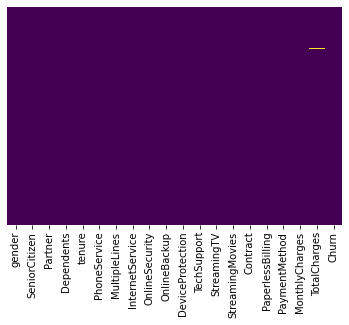

In [17]:
sns.heatmap(df.isnull(),cbar=False,yticklabels=False,cmap = 'viridis')

# Check for Outliers

In [18]:
numerical_cols = ['tenure','MonthlyCharges', 'TotalCharges']

In [19]:
# df.at[0,'tenure']=200

In [20]:
def outlier_boxplot(df, numerical_cols):
    fig, axs = plt.subplots(len(numerical_cols), figsize=(8, 8))

    for i, col in enumerate(numerical_cols):
        sns.set_style('whitegrid')
        sns.boxplot(y=df[col],color='green',orient='v', ax = axs[i])
        plt.tight_layout()

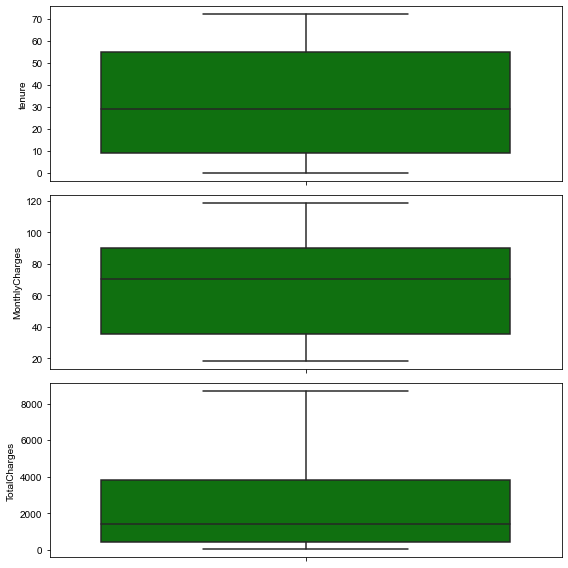

In [21]:
outlier_boxplot(df, numerical_cols)

# Correlation Matrix

<AxesSubplot:>

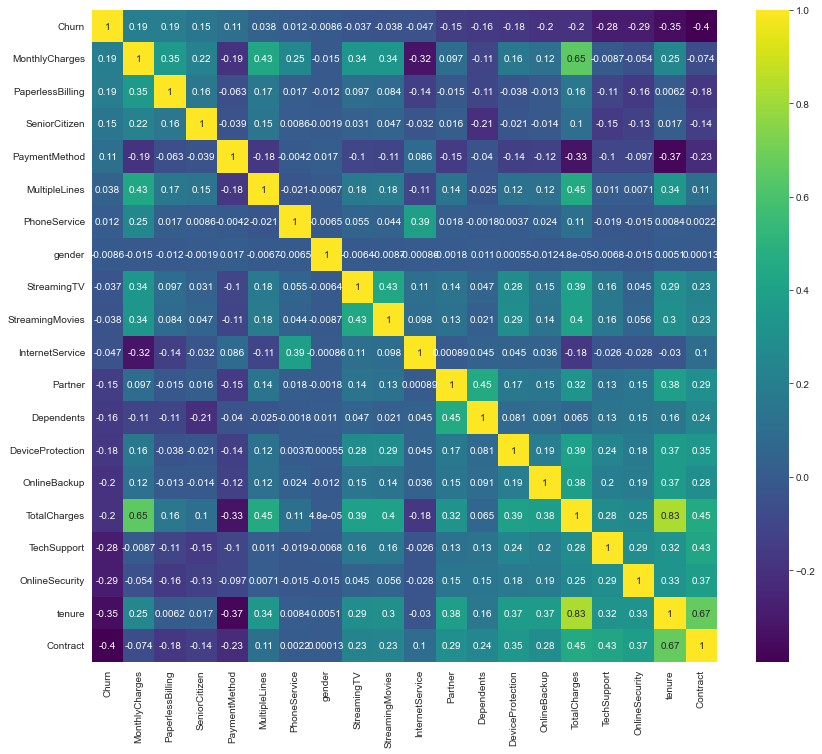

In [22]:
k = len(df.columns) #number of variables for heatmap
cols = df.corr().nlargest(k, 'Churn')['Churn'].index
cm = df[cols].corr()
plt.figure(figsize=(14,12))
sns.heatmap(cm, annot=True, cmap = 'viridis')

# Univariate Analysis
Table

## Numerical Features vs Numerical Labels
Scatterplot -- not covered in this blog

## Numerical Features vs Categorial Labels

### Histograms

In [23]:
numerical_cols = ['tenure','MonthlyCharges', 'TotalCharges']

In [24]:
def uni_histogram(df, feature, target):
    fig, ax = plt.subplots(figsize=(8, 6))

    ax.hist(df[df[target]==1][feature], bins=15, alpha=0.5, color="blue", label="Churn")
    ax.hist(df[df[target]==0][feature], bins=15, alpha=0.5, color="green", label="No Churn")

    ax.set_xlabel(feature)
    ax.set_ylabel(f"Count of {target}")

    fig.suptitle(f"{feature} vs. {target}")

    ax.legend();

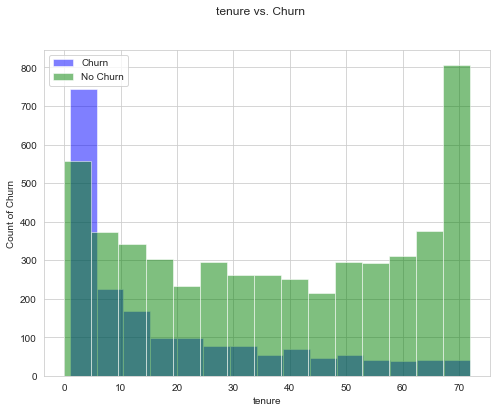

In [25]:
uni_histogram(df, 'tenure', 'Churn')

In [26]:
def uni_kde(df, feature, target, classes=None):
    fig, ax = plt.subplots(figsize=(8, 6))

    sns.kdeplot(df[df[target]==1][feature], shade=True, color="blue", label="Churn", ax=ax)
    sns.kdeplot(df[df[target]==0][feature], shade=True, color="green", label="No Churn", ax=ax)

    ax.legend(labels=classes)
    ax.set_xlabel(feature)
    ax.set_ylabel(f"Count of {target}")

    fig.suptitle(f"{feature} vs. {target}");

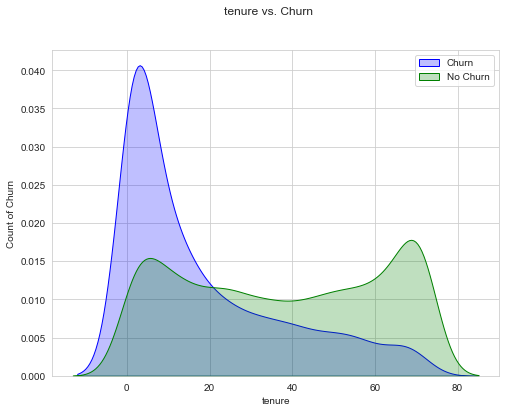

In [27]:
classes = ['Churn', 'No Churn']
uni_kde(df, 'tenure', 'Churn', classes)

## Categorical vs Categorical Features

### Grouped Bar Chart

In [28]:
encoder.categories_

[array(['Female', 'Male'], dtype=object),
 array(['No', 'Yes'], dtype=object),
 array(['No', 'Yes'], dtype=object),
 array(['No', 'Yes'], dtype=object),
 array(['No', 'No phone service', 'Yes'], dtype=object),
 array(['DSL', 'Fiber optic', 'No'], dtype=object),
 array(['No', 'No internet service', 'Yes'], dtype=object),
 array(['No', 'No internet service', 'Yes'], dtype=object),
 array(['No', 'No internet service', 'Yes'], dtype=object),
 array(['No', 'No internet service', 'Yes'], dtype=object),
 array(['No', 'No internet service', 'Yes'], dtype=object),
 array(['No', 'No internet service', 'Yes'], dtype=object),
 array(['Month-to-month', 'One year', 'Two year'], dtype=object),
 array(['No', 'Yes'], dtype=object),
 array(['Bank transfer (automatic)', 'Credit card (automatic)',
        'Electronic check', 'Mailed check'], dtype=object),
 array(['No', 'Yes'], dtype=object)]

In [29]:
from matplotlib.patches import Patch

def uni_bar_chart(df, feature, target, x_classes):
    fig, ax = plt.subplots(figsize=(8, 6))

    sns.countplot(x=feature, hue=target, data=df, 
                palette={0:"green",1:"blue" }, ax=ax)
    
    ax.set_xticklabels(x_classes, rotation=45)
    ax.set_xlabel(feature)
    
    color_patches = [
        Patch(facecolor="blue", label="Churn"),
        Patch(facecolor="green", label="No Churn")
    ]
    ax.legend(handles=color_patches)

    fig.suptitle(f"{feature} vs. {target}");

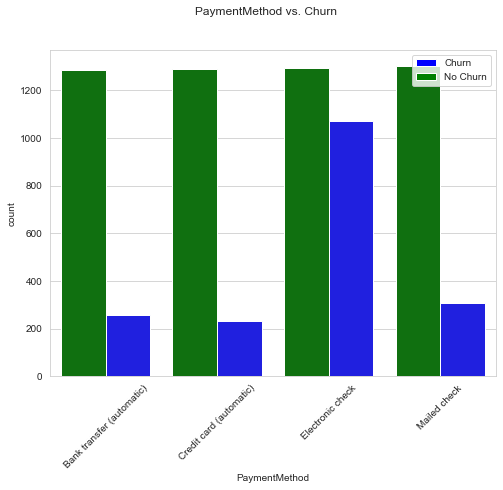

In [30]:
x_classes = ['Bank transfer (automatic)', 'Credit card (automatic)','Electronic check', 'Mailed check']


uni_bar_chart(df, 'PaymentMethod', 'Churn', x_classes=x_classes)

In [31]:
def uni_bar_chart_inverse(df, feature, target, classes):
    fig, ax = plt.subplots(figsize=(8, 6))

    sns.countplot(x=target, hue=feature, data=df, 
                  palette={0:"yellow", 1:"orange", 2:"red", 3:"purple"}, ax=ax)
    
    ax.set_xlabel(feature)
    
    ax.legend(labels=classes)

    ax.set_xlabel(target)

    fig.suptitle(f"{target} vs. {feature}");

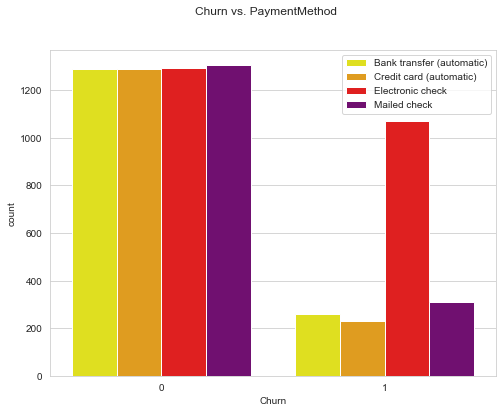

In [32]:
classes = ['Bank transfer (automatic)', 'Credit card (automatic)','Electronic check', 'Mailed check']

uni_bar_chart_inverse(df, 'PaymentMethod', 'Churn', classes=classes)

### Stacked Bar Chart

In [33]:
def uni_stacked_bar_chart(df, feature, target, x_classes=None):
    
    counts_df = df.groupby([feature, target])[target].count().unstack()
    survived_percents_df = counts_df.T.div(counts_df.T.sum()).T
    
    fig, ax = plt.subplots(figsize=(8, 6))

    survived_percents_df.plot(kind="bar", stacked=True, color=["green", "blue"], ax=ax)

    ax.set_xlabel(feature)
    ax.set_xticklabels(x_classes, rotation=45)
    ax.set_ylabel("Proportion")

    color_patches = [
        Patch(facecolor="blue", label="Churn"),
        Patch(facecolor="green", label="No Churn")
    ]
    ax.legend(handles=color_patches)

    fig.suptitle(f"{feature} vs. {target}");



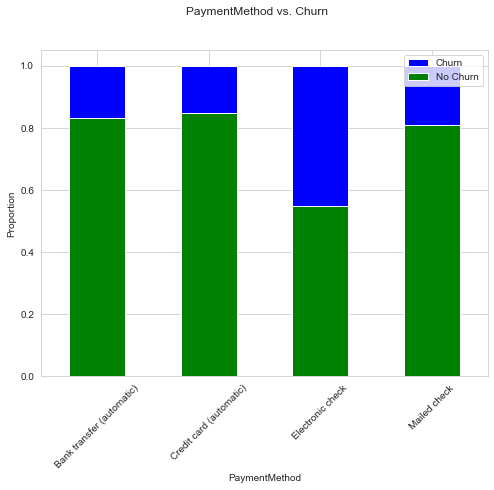

In [34]:
classes = ['Bank transfer (automatic)', 'Credit card (automatic)','Electronic check', 'Mailed check']

uni_stacked_bar_chart(df, 'PaymentMethod', 'Churn', x_classes=classes )

# Multivariate Analysis 

### Simplest-scatterplot 
Pros: Easy to visualise

Cons: Computational Expensive

In [35]:
def multi_scatterplot(df, feature1, feature2, target):
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.scatterplot(data=df, x=feature1, y=feature2, hue=target, ax=ax, palette={0:"green",1:"blue" })
    
    color_patches = [
        Patch(facecolor="blue", label="Churn"),
        Patch(facecolor="green", label="No Churn")
    ]
    ax.legend(handles=color_patches)

    plt.show()

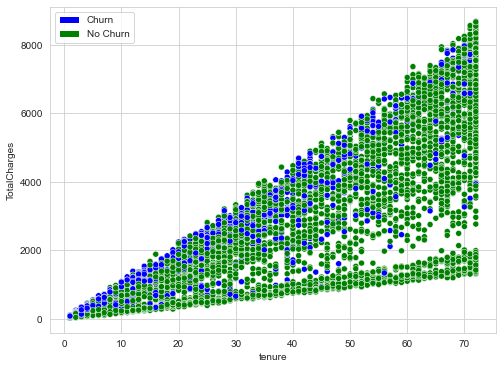

In [36]:
multi_scatterplot(df, "tenure","TotalCharges", "Churn" )

### Shortcut: Pair Plot

In [37]:
def multi_pair_plot(df, features, target):
    sns.pairplot(data = df, 
                 hue= target,
                 palette={0:"green",1:"blue" },
                 vars = features,
                 height=3
                )


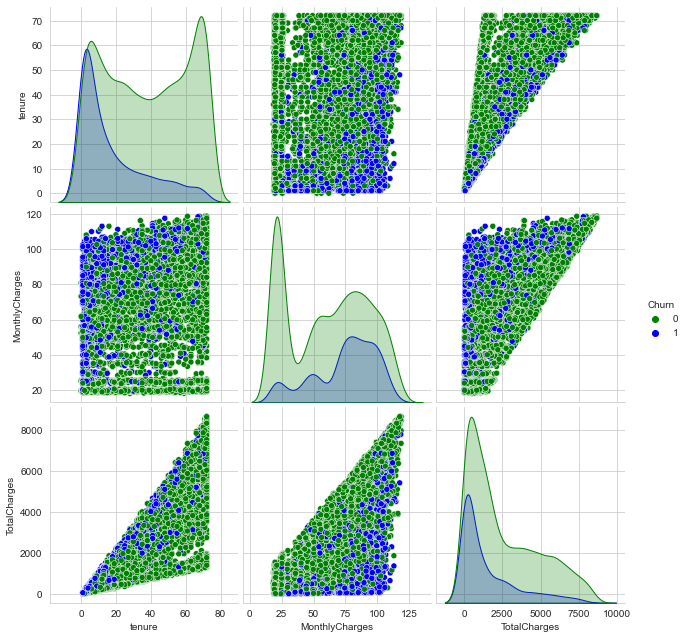

In [38]:
features_to_explore = ["tenure","MonthlyCharges","TotalCharges"]
multi_pair_plot(df, features_to_explore, "Churn")

# Appendix

In [39]:
'''
Histogram for multi-variate analysis is bad because 
the hue of 1 class overrides the other. 
Modifying the hue_order does not help
'''
    
def multi_hist_plot(df, feature1, feature2, target):
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.histplot(data=df, x=feature1, y=feature2, 
                 hue=target, 
                 hue_norm = (0, 255),
                 hue_order=[1,0], # changing this to [0,1] does not help 
                 ax=ax, 
                 palette={0:"green",1:"blue" }
                )
    
    color_patches = [
        Patch(facecolor="blue", label="Churn"),
        Patch(facecolor="green", label="No Churn")
    ]
    ax.legend(handles=color_patches)

    plt.show()

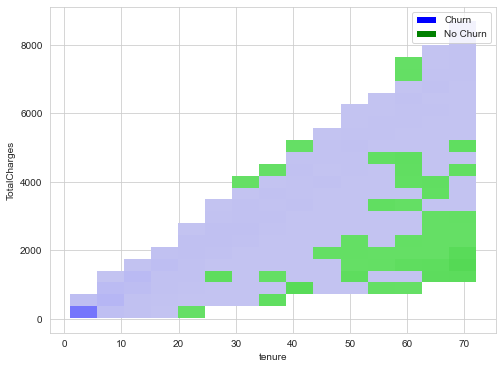

In [40]:
multi_hist_plot(df, "tenure","TotalCharges", "Churn" )